## Desafio - Regressão Polinominal - Desenvolvimento de IA - Rockeseat

## Sobre o desafio

Você é um analista de dados em uma empresa de vendas e deseja prever a receita de vendas de um vendedor com base no seu tempo de experiência na empresa, o número de vendas que ele realiza, e um fator sazonal que pode afetar os resultados (por exemplo, meses de alta e baixa demanda).

### Dataset:

- `tempo_de_experiencia`: Tempo em meses que o vendedor trabalha na empresa.
- `numero_de_vendas`: Número de vendas realizadas pelo vendedor em um período específico.
- `fator_sazonal`: Um fator (de 1 a 10) que representa a sazonalidade das vendas (ex: 10 representa alta temporada).
- `receita_em_reais`: Receita total gerada pelo vendedor.

### Tarefa:

1. **Carregamento de Dados**: Carregar o dataset no Python usando o Pandas.
2. **Exploração dos Dados**: Realizar uma análise exploratória dos dados, visualizando correlações entre as variáveis.
3. **Divisão dos Dados**: Separar os dados em conjuntos de treinamento e teste.
4. **Modelo de Regressão Linear**:
    - Treinar um modelo de regressão linear para prever a receita com base no tempo de experiência e no número de vendas.
    - Avaliar o desempenho do modelo usando métricas como o MSE (Mean Squared Error) e o R².
5. **Modelo de Regressão Polinomial**:
    - Treinar um modelo de regressão polinomial, incluindo o fator sazonal como uma variável adicional.
    - Avaliar se o modelo polinomial oferece um desempenho superior ao modelo linear simples.
6. **Comparação dos Modelos**: Comparar os resultados e decidir qual modelo é mais adequado para prever a receita com base nas variáveis fornecidas.

### Bibliotecas

In [1]:
# Bibliotecas a serem instaladas e usadas

# pipenv install scikit-learn scipy pandas matplotlib seaborn ipykernel pingouin fastapi pydantic streamlit uvicorn requests 

import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, root_mean_squared_error

import numpy as np

from scipy.stats import zscore 

import pingouin as pg

from scipy.stats import shapiro, kstest
from statsmodels.stats.diagnostic import lilliefors

import joblib

### 1. Carregamento de Dados:

In [2]:
# Carregar o Dataset
df_sales = pd.read_csv('./datasets/sales_data.csv')

### 2. Exploração dos Dados (EDA):

In [3]:
# Inspecionar a estrutura do Dataframe
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   tempo_de_experiencia  100 non-null    int64  
 1   numero_de_vendas      100 non-null    int64  
 2   fator_sazonal         100 non-null    int64  
 3   receita_em_reais      100 non-null    float64
dtypes: float64(1), int64(3)
memory usage: 3.2 KB


In [4]:
# Detectar valores ausentes
df_sales.isna().sum()

tempo_de_experiencia    0
numero_de_vendas        0
fator_sazonal           0
receita_em_reais        0
dtype: int64

In [5]:
# Medidas básicas do Dataframe
df_sales.describe()

,tempo_de_experiencia,numero_de_vendas,fator_sazonal,receita_em_reais
count,100.000000,100.000000,100.000000,100.000000
mean,64.490000,54.490000,5.820000,5112.941924
std,32.397935,25.307201,2.836914,2544.731052
min,1.000000,10.000000,1.000000,1133.363948
25%,38.750000,37.500000,4.000000,2800.660516
50%,64.500000,52.500000,5.000000,4953.770034
75%,93.000000,70.500000,8.000000,7079.500163
max,119.000000,100.000000,10.000000,9941.016458


<Axes: xlabel='tempo_de_experiencia'>

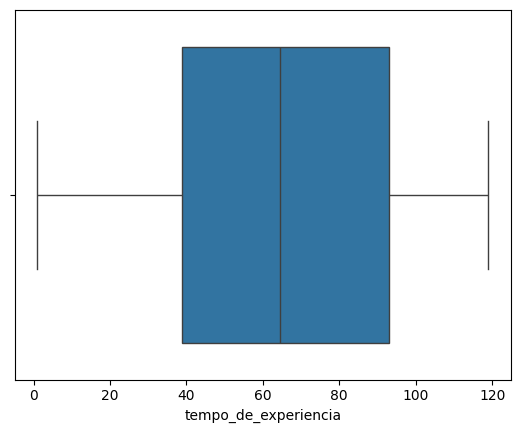

In [6]:
# Detectar outliers
sns.boxplot(data=df_sales, x='tempo_de_experiencia')

<Axes: xlabel='numero_de_vendas'>

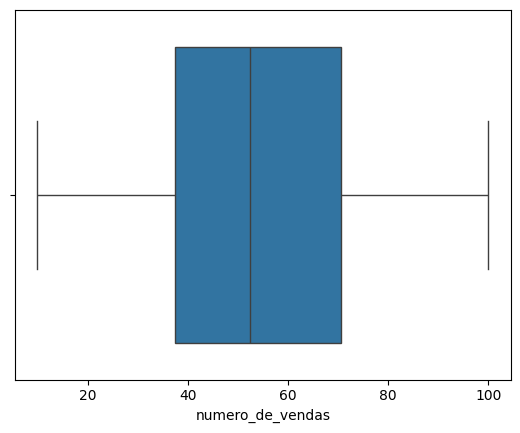

In [7]:
# Detectar outliers
sns.boxplot(data=df_sales, x='numero_de_vendas')

<Axes: xlabel='fator_sazonal'>

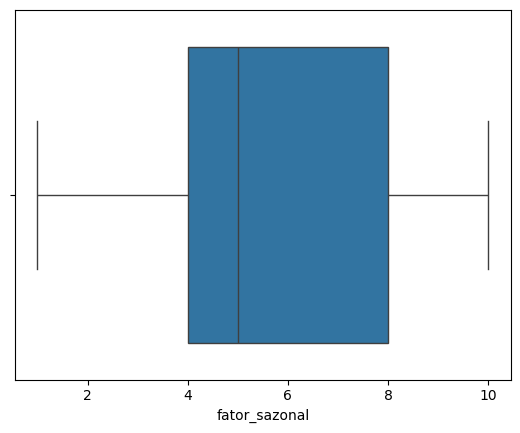

In [8]:
# Detectar outliers
sns.boxplot(data=df_sales, x='fator_sazonal')

<Axes: xlabel='receita_em_reais'>

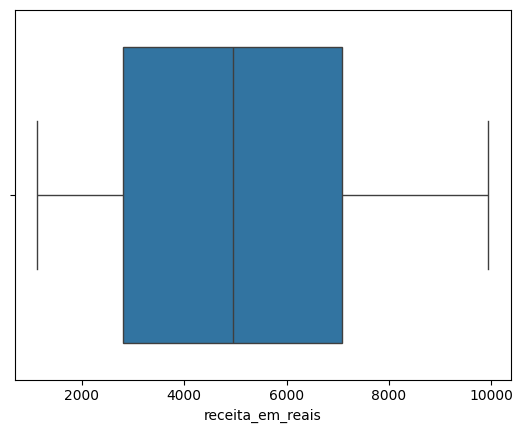

In [9]:
# Detectar outliers
sns.boxplot(data=df_sales, x='receita_em_reais')

<Axes: xlabel='tempo_de_experiencia', ylabel='receita_em_reais'>

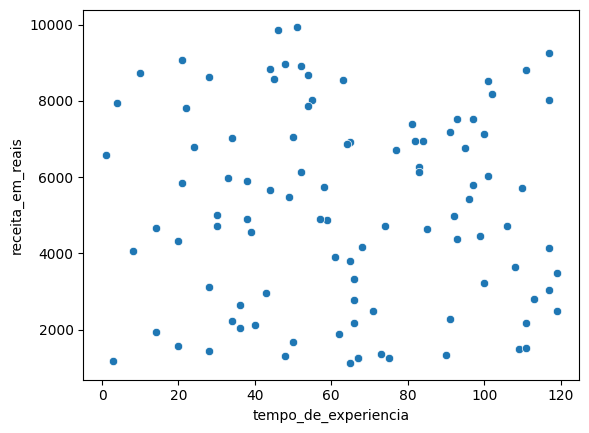

In [10]:
# Cruzamento das variáveis numéricas com variável target

sns.scatterplot(data=df_sales, x="tempo_de_experiencia", y="receita_em_reais")
# Não há forte correlação

<Axes: xlabel='numero_de_vendas', ylabel='receita_em_reais'>

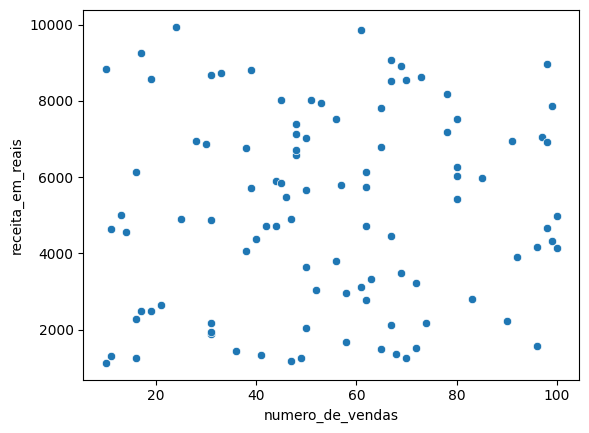

In [11]:
# Cruzamento das variáveis numéricas com variável target

sns.scatterplot(data=df_sales, x="numero_de_vendas", y="receita_em_reais")
# Não há forte correlação

<Axes: xlabel='fator_sazonal', ylabel='receita_em_reais'>

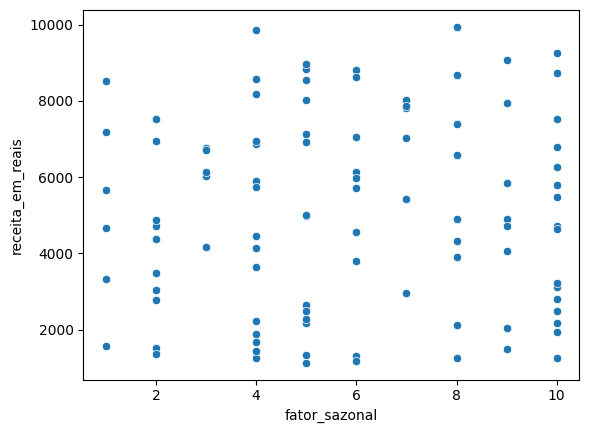

In [12]:
# Cruzamento das variáveis numéricas com variável target

sns.scatterplot(data=df_sales, x="fator_sazonal", y="receita_em_reais")
# Não há forte correlação

<Axes: >

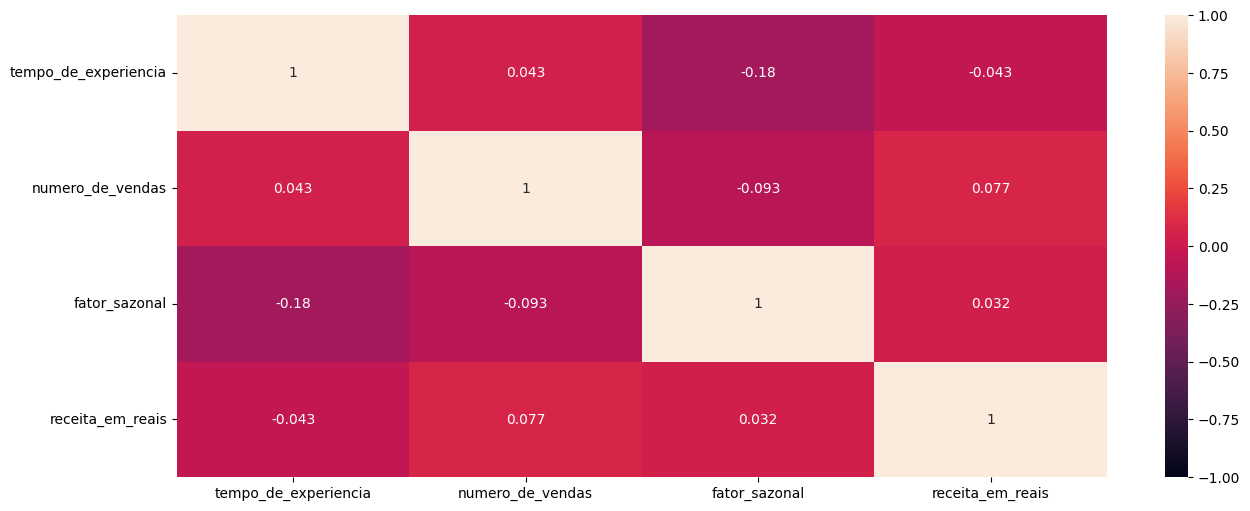

In [13]:
# Mapa de calor Pearson
plt.figure(figsize=(15,6))
sns.heatmap(df_sales.corr(), vmin=-1, vmax=1, annot=True)

<Axes: >

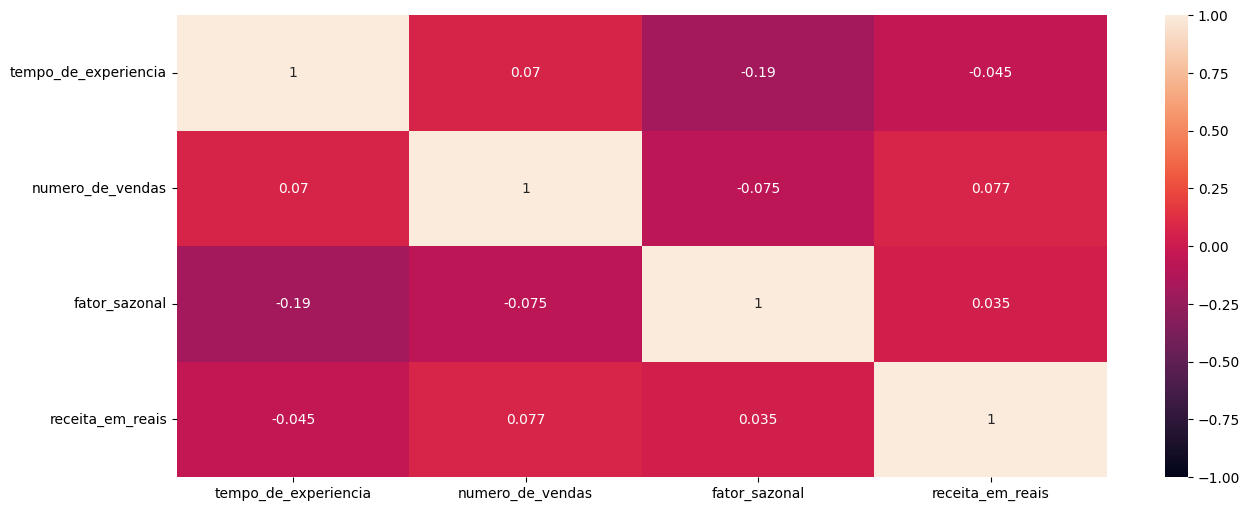

In [14]:
# Mapa de calor Spearman
plt.figure(figsize=(15,6))
sns.heatmap(df_sales.corr("spearman"), vmin=-1, vmax=1, annot=True)

<Axes: >

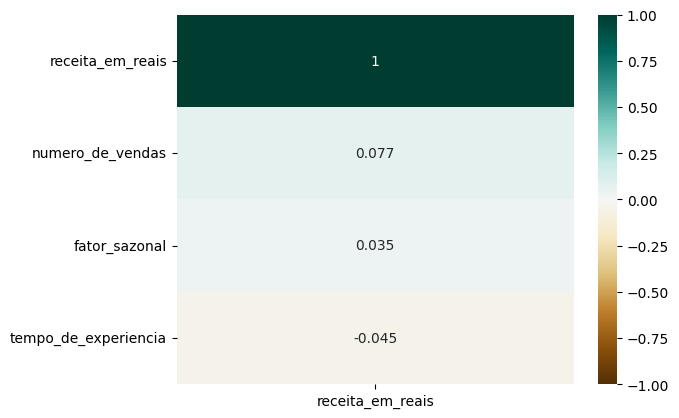

In [15]:
# Formato de ranking
sns.heatmap(df_sales.corr('spearman')[['receita_em_reais']].sort_values (by='receita_em_reais', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')

### 3. Divisão dos Dados - Treino e Teste:

In [16]:
# Criar o Dataset de treino e teste
# O X deve conter todos os dados do dataframe menos a coluna de target
X = df_sales.drop(columns='receita_em_reais', axis=1)
y = df_sales['receita_em_reais']

In [17]:
# Split usando Kfold com 5 pastas/splits 
kf = KFold(n_splits=5, shuffle=True, random_state=51)

In [18]:
kf

KFold(n_splits=5, random_state=51, shuffle=True)

### 4. Modelo de Regressão Linear (sem a feature "fator_sazonal"):

In [19]:
# Bloco para treinamento do modelo

# Pipeline
# Padronização de variáveis numéricas - tempo_na_empresa, nivel_na_empresa

# Nomes das colunas 
colunas_numericas = ['tempo_de_experiencia', 'numero_de_vendas']

# Transformer para colunas numéricas
transformer_numericas = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Criar um ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformer_numericas, colunas_numericas)
    ]
)

# Criar o pipeline principal = preprocessamento + treinamento 
model_regr = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', LinearRegression())])

# Armazenar RMSE treino e teste (validar overfiting)
rmse_scores_fold_train = []
rmse_scores_fold_test = []

# Armazenar o R2 Score de teste
r2score_fold_test = []

# Armazenar resíduos 
residuos = []

# Armazenar predições
y_pred_total = []

# Iteração
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Treinar o modelo no conjunto de treinamento
    model_regr.fit(X_train, y_train)

    # Faça predições nos conjuntos de treinamento e teste
    y_train_pred = model_regr.predict(X_train)
    y_test_pred_linear = model_regr.predict(X_test)

    # Calcular o RMSE para os conjuntos de treinamento 
    rmse_train = root_mean_squared_error(y_train, y_train_pred)
    rmse_test = root_mean_squared_error(y_test, y_test_pred_linear)

    # Calcular R2Score para conjunto de teste 
    r2score_test = r2_score(y_test, y_test_pred_linear)
    residuos_test = np.array(y_test - y_test_pred_linear)

    # Armazenamento das métricas da interação na lista
    rmse_scores_fold_train.append(rmse_train)
    rmse_scores_fold_test.append(rmse_test)
    r2score_fold_test.append(r2score_test)
    residuos.append(residuos_test)
    y_pred_total.append(y_test_pred_linear)

# Valores de cada iteração, calculando a média e armazenando 
rmse_train_final = np.mean(rmse_scores_fold_train)
rmse_test_final = np.mean(rmse_scores_fold_test)
r2_score_test_final = np.mean(r2score_fold_test)
percentual_rmse_final = ((rmse_test_final - rmse_train_final) / rmse_train_final) * 100
residuos = np.array(residuos).reshape(-1)
y_pred_total = np.array(y_pred_total).reshape(-1)

In [20]:
# Métricas 
print(f'RMSE treino: {rmse_train_final}')
print(f'RMSE teste: {rmse_test_final}')
print(f'% Difrença RMSE treino e teste: {percentual_rmse_final}')
print(f'R2Score teste: {r2_score_test_final}')

RMSE treino: 2506.4020236861
RMSE teste: 2646.215898584393
% Difrença RMSE treino e teste: 5.578270108985637
R2Score teste: -0.13451763390799448


A diferença percentual entre os dois é de apenas 5.58%, indicando que o modelo não está sofrendo de overfitting (o desempenho no treino e no teste é semelhante).
O R² Score para o conjunto de teste é -0.1345, o que significa que o modelo não consegue explicar a variância dos dados. Um valor negativo indica que o modelo está pior do que simplesmente prever a média da variável target.

O modelo de regressão linear não é adequado para este problema, pois não consegue capturar a relação entre as variáveis preditoras (tempo_de_experiencia e numero_de_vendas) e a variável target (receita_em_reais).
Isso pode ser devido à falta de correlação entre as variáveis ou à necessidade de um modelo mais complexo (como regressão polinomial ou outro tipo de modelo não linear) ou a inclusão de mais variáveis, tal como o fator_sazonal, que iremos incluir no Modelo Polinomial abaixo.

In [21]:
# Transformar os resíduos na escala padrão
# (X - média) / desvio padrão
from scipy.stats import zscore 
residuos_std = zscore(residuos)

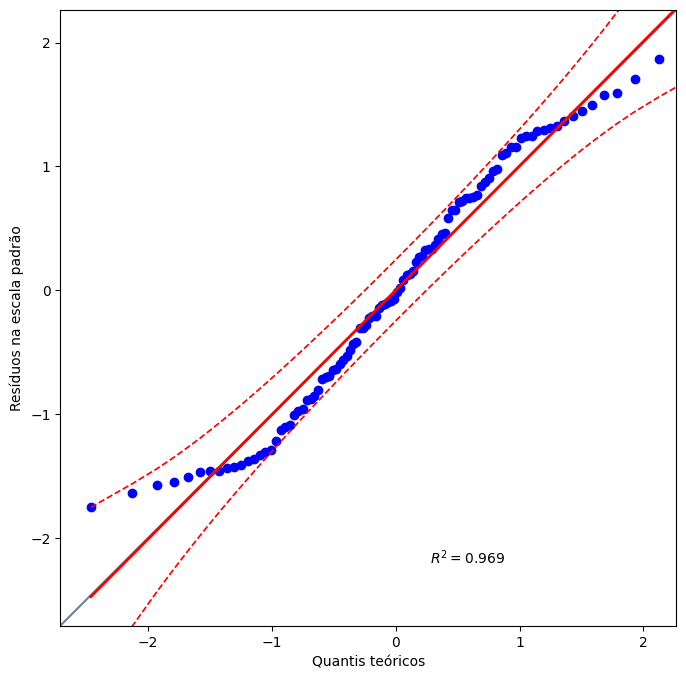

In [22]:
# Checar se resíduos segue uma distribuição normal 
# QQ Plot
import pingouin as pg

plt.figure(figsize=(14,8))
pg.qqplot(residuos_std, dist='norm', confidence=0.95)
plt.xlabel('Quantis teóricos')
plt.ylabel('Resíduos na escala padrão')
plt.show()

### 5. Modelo de Regressão Polinomial:

In [23]:
# Criar modelo com polinomios, além dos padrões lineares
feat_poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = feat_poly.fit_transform(X)
feat_poly.feature_names_in_

array(['tempo_de_experiencia', 'numero_de_vendas', 'fator_sazonal'],
      dtype=object)

In [24]:
# Verificar todas as features geradas
feat_poly.get_feature_names_out(feat_poly.feature_names_in_)

array(['tempo_de_experiencia', 'numero_de_vendas', 'fator_sazonal',
       'tempo_de_experiencia^2', 'tempo_de_experiencia numero_de_vendas',
       'tempo_de_experiencia fator_sazonal', 'numero_de_vendas^2',
       'numero_de_vendas fator_sazonal', 'fator_sazonal^2'], dtype=object)

In [25]:
# Bloco para treinamento do modelo

# Criando 10 modelos
graus_polynomial = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] 

rmse_train_values = []
rmse_test_values = []
percentual_rmse_values = []
r2score_test_values = []

# Split usando Kfold com 5 pastas/splits 
kf = KFold(n_splits=5, shuffle=True, random_state=51)

for grau in graus_polynomial:

    # Pipeline
    # Padronização de variáveis numéricas

    # Nomes das colunas 
    colunas_numericas = ['tempo_de_experiencia', 'numero_de_vendas', 'fator_sazonal']

    # Transformer para colunas numéricas
    transformer_numericas = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    # Criar um ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', transformer_numericas, colunas_numericas)
        ]
    )

    # Criar features polinomiais
    poly_feat = PolynomialFeatures(degree=grau, include_bias=False)

    # Criar o pipeline principal = preprocessamento + treinamento 
    model_poly = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('poly_features', poly_feat),
                                ('regressor', LinearRegression())])

    # Armazenar RMSE treino e teste (validar overfiting)
    rmse_scores_fold_train = []
    rmse_scores_fold_test = []

    # Armazenar o R2 Score de teste
    r2score_fold_test = []

    # Armazenar resíduos 
    residuos = []

    # Armazenar predições
    y_pred_total = []

    # Iteração
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Treinar o modelo no conjunto de treinamento
        model_poly.fit(X_train, y_train)

        # Faça predições nos conjuntos de treinamento e teste
        y_train_pred = model_poly.predict(X_train)
        y_test_pred = model_poly.predict(X_test)

        # Calcular o RMSE para os conjuntos de treinamento 
        rmse_train = root_mean_squared_error(y_train, y_train_pred)
        rmse_test = root_mean_squared_error(y_test, y_test_pred)

        # Calcular R2Score para conjunto de teste 
        r2score_test = r2_score(y_test, y_test_pred)
        residuos_test = np.array(y_test - y_test_pred)

        # Armazenamento das métricas da interação na lista
        rmse_scores_fold_train.append(rmse_train)
        rmse_scores_fold_test.append(rmse_test)
        r2score_fold_test.append(r2score_test)
        residuos.append(residuos_test)
        y_pred_total.append(y_test_pred)

    # Valores de cada iteração, calculando a média e armazenando 
    rmse_train_final = np.mean(rmse_scores_fold_train)
    rmse_test_final = np.mean(rmse_scores_fold_test)
    r2_score_test_final = np.mean(r2score_fold_test)
    percentual_rmse_final = ((rmse_test_final - rmse_train_final) / rmse_train_final) * 100
    residuos = np.array(residuos).reshape(-1)
    y_pred_total = np.array(y_pred_total).reshape(-1)

    rmse_train_values.append(rmse_train_final)
    rmse_test_values.append(rmse_test_final)
    r2score_test_values.append(r2_score_test_final)
    percentual_rmse_values.append(percentual_rmse_final)

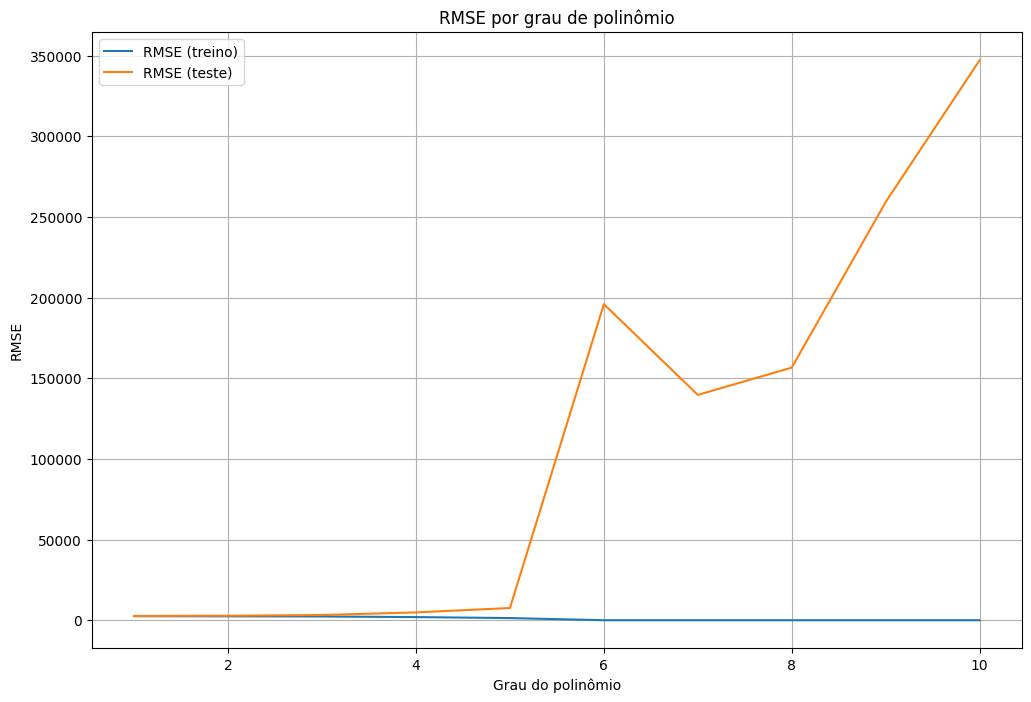

In [26]:
# Plotar gráfico parar comparar RMSE por grau de polinômio
plt.figure(figsize=(12,8))
plt.plot(graus_polynomial, rmse_train_values, label='RMSE (treino)')
plt.plot(graus_polynomial, rmse_test_values, label='RMSE (teste)')
plt.xlabel('Grau do polinômio')
plt.ylabel('RMSE')
plt.title('RMSE por grau de polinômio')
plt.legend()
plt.grid()
plt.show()

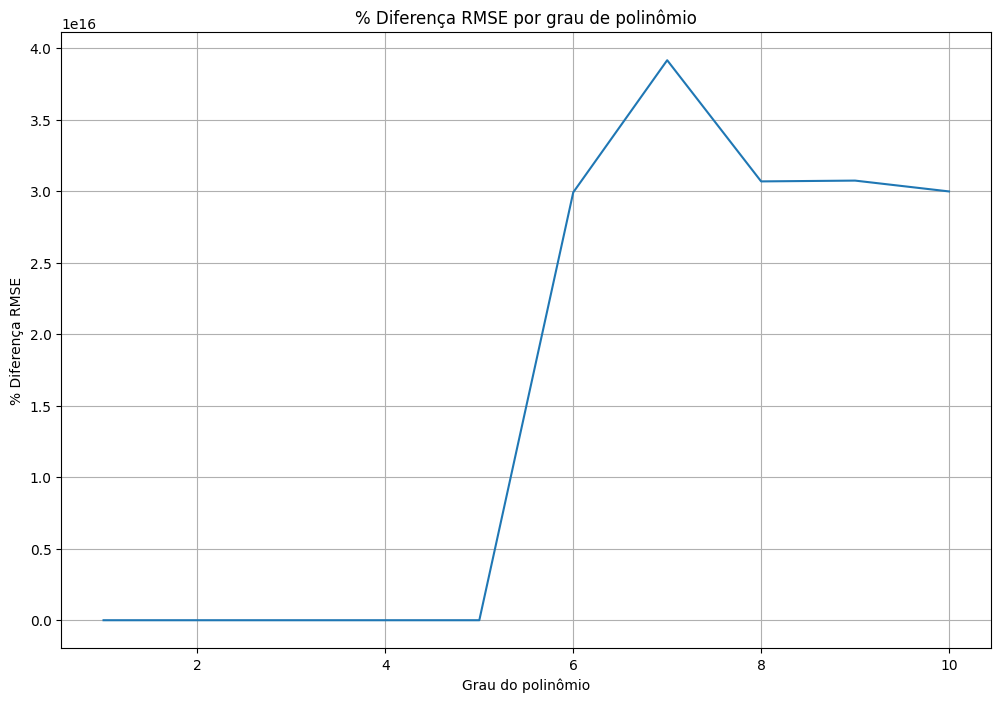

In [27]:
# Plotar gráfico parar comparar percentual de diferença RMSE (treino e teste)
plt.figure(figsize=(12,8))
plt.plot(graus_polynomial, percentual_rmse_values, label='% Diferença RMSE treino e teste')
plt.xlabel('Grau do polinômio')
plt.ylabel('% Diferença RMSE')
plt.title('% Diferença RMSE por grau de polinômio')
plt.grid()
plt.show()

Conclusão sobre os dois gráficos:
se usarmos um grau de polinômio 3, ainda teremos uma possibilidade de um ganho de redução de erro sem comprometer o overfiting e usando 
acima de 3, poderemos ter um problema de generalização ou overfiting, já que os dados de treino e teste quase que se igualam.
sendo assim, o modelo ideal de modelo deve ser usado com um grau de polinômio 2 ou 3.

In [28]:
# Bloco para treinamento do modelo com GRAU DE POLINÔMIO 2 - com a feature "fator_sazonal"

# Criando 10 modelos
# graus_polynomial = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] 
graus_polynomial = [2] 

rmse_train_values = []
rmse_test_values = []
percentual_rmse_values = []
r2score_test_values = []

# Split usando Kfold com 5 pastas/splits 
kf = KFold(n_splits=5, shuffle=True, random_state=51)

for grau in graus_polynomial:

    # Pipeline
    # Padronização de variáveis numéricas - tempo_na_empresa, nivel_na_empresa

    # Nomes das colunas 
    colunas_numericas = ['tempo_de_experiencia', 'numero_de_vendas', 'fator_sazonal']

    # Transformer para colunas numéricas
    transformer_numericas = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    # Criar um ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', transformer_numericas, colunas_numericas)
        ]
    )

    # Criar features polinomiais
    poly_feat = PolynomialFeatures(degree=grau, include_bias=False)

    # Criar o pipeline principal = preprocessamento + treinamento 
    model_poly = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('poly_features', poly_feat),
                                ('regressor', LinearRegression())])

    # Armazenar RMSE treino e teste (validar overfiting)
    rmse_scores_fold_train = []
    rmse_scores_fold_test = []

    # Armazenar o R2 Score de teste
    r2score_fold_test = []

    # Armazenar resíduos 
    residuos = []

    # Armazenar predições
    y_pred_total = []

    # Iteração
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Treinar o modelo no conjunto de treinamento
        model_poly.fit(X_train, y_train)

        # Faça predições nos conjuntos de treinamento e teste
        y_train_pred = model_poly.predict(X_train)
        y_test_pred_poly = model_poly.predict(X_test)

        # Calcular o RMSE para os conjuntos de treinamento 
        rmse_train = root_mean_squared_error(y_train, y_train_pred)
        rmse_test = root_mean_squared_error(y_test, y_test_pred_poly)

        # Calcular R2Score para conjunto de teste 
        r2score_test = r2_score(y_test, y_test_pred_poly)
        residuos_test = np.array(y_test - y_test_pred_poly)

        # Armazenamento das métricas da interação na lista
        rmse_scores_fold_train.append(rmse_train)
        rmse_scores_fold_test.append(rmse_test)
        r2score_fold_test.append(r2score_test)
        residuos.append(residuos_test)
        y_pred_total.append(y_test_pred_poly)

    # Valores de cada iteração, calculando a média e armazenando 
    rmse_train_final = np.mean(rmse_scores_fold_train)
    rmse_test_final = np.mean(rmse_scores_fold_test)
    r2_score_test_final = np.mean(r2score_fold_test)
    percentual_rmse_final = ((rmse_test_final - rmse_train_final) / rmse_train_final) * 100
    residuos = np.array(residuos).reshape(-1)
    y_pred_total = np.array(y_pred_total).reshape(-1)

    rmse_train_values.append(rmse_train_final)
    rmse_test_values.append(rmse_test_final)
    r2score_test_values.append(r2_score_test_final)
    percentual_rmse_values.append(percentual_rmse_final)

In [29]:
# Métricas com grau 2
print(f'RMSE treino: {rmse_train_final}')
print(f'RMSE teste: {rmse_test_final}')
print(f'% Difrença RMSE treino e teste: {percentual_rmse_final}')
print(f'R2Score teste: {r2_score_test_final}')

RMSE treino: 2423.5170534288945
RMSE teste: 2775.008357109534
% Difrença RMSE treino e teste: 14.503355905143497
R2Score teste: -0.2466649072431138


### 6. Comparação dos Modelos:

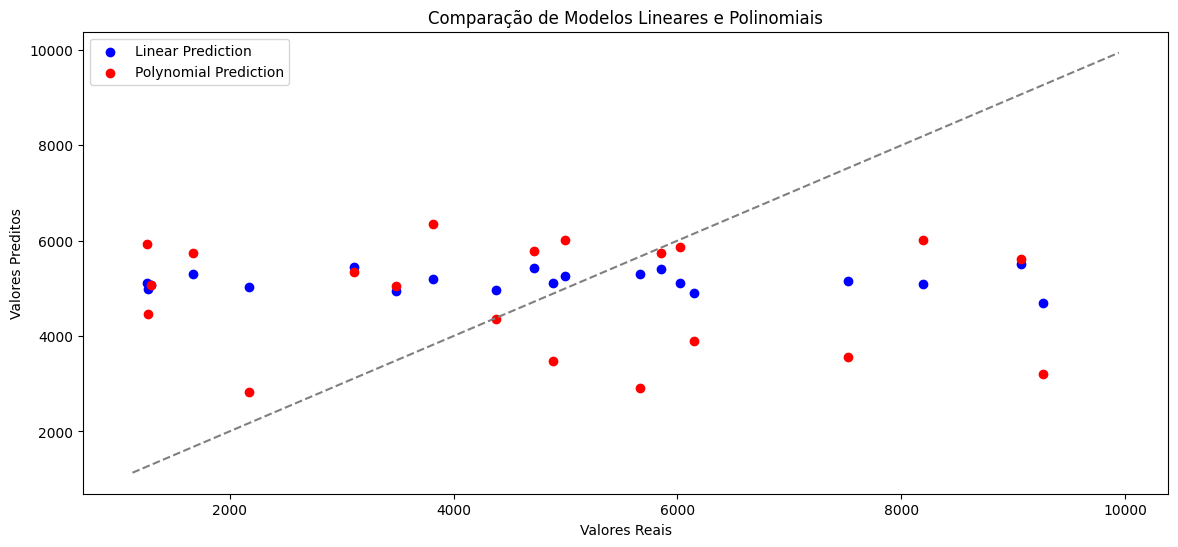

In [30]:
# Comparação Gráfica
plt.figure(figsize=(14, 6))
plt.scatter(y_test, y_test_pred_linear, color='blue', label='Linear Prediction')
plt.scatter(y_test, y_test_pred_poly, color='red', label='Polynomial Prediction')
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='gray')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')
plt.title('Comparação de Modelos Lineares e Polinomiais')
plt.legend()
plt.show()

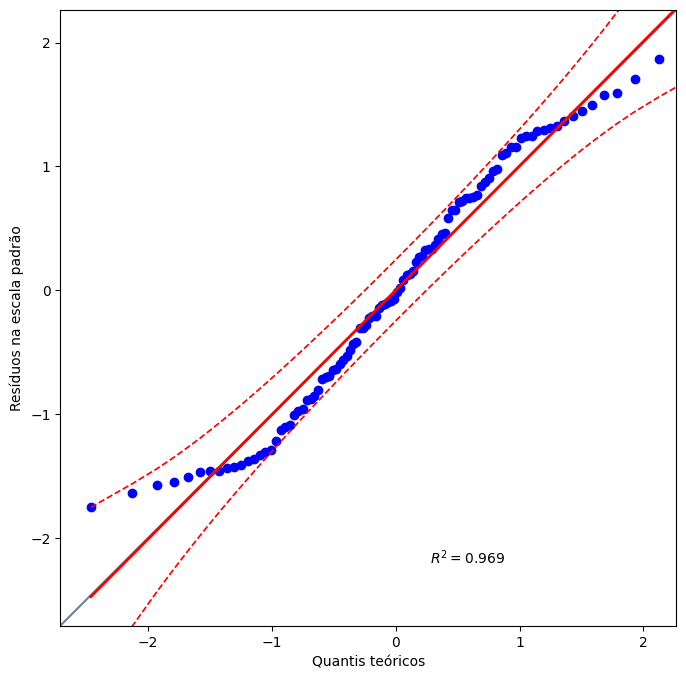

In [31]:
# Checar se resíduos segue uma distribuição normal 
# QQ Plot
import pingouin as pg

plt.figure(figsize=(14,8))
pg.qqplot(residuos_std, dist='norm', confidence=0.95)
plt.xlabel('Quantis teóricos')
plt.ylabel('Resíduos na escala padrão')
plt.show()

In [32]:
# Teste de normalidade - Shapiro-Wilk 
# Um P-Value menor que 0.05 indica que os resíduos não seguem uma distribuição normal
# Neste caso, como o P-Value é 0.0313, rejeitamos a hipótese nula (os resíduos não são normalmente distribuídos)
from scipy.stats import shapiro, kstest
from statsmodels.stats.diagnostic import lilliefors

stat_shapiro, p_value_shapiro = shapiro(residuos)
print(f'Estástica teste {stat_shapiro} e P-Value {p_value_shapiro}')

Estástica teste 0.9719685335705001 e P-Value 0.03133396932539388


In [33]:
# Teste de normalidade - Lillierfors
# Um P-Value maior que 0.05 indica que não há evidências suficientes para rejeitar a hipótese de normalidade
# Neste caso, como o P-Value é 0.1851, aceitamos a hipótese nula (os resíduos podem ser considerados normalmente distribuídos)
stat_ll, p_value_ll = lilliefors(residuos, dist='norm', pvalmethod='table')
print(f'Estástica teste {stat_ll} e P-Value {p_value_ll}')

Estástica teste 0.07546356887253924 e P-Value 0.18511179596819533


Conclusão:

Ambos modelos não tiveram resultado de predição satisfatório, onde o modelo linear e o modelo polinomial obtiveram o resultado de R2Score negativo e por mais ajustes feitos, ainda sim não foram tiveram um resultado confiável ou até mesmo o dataframe não apresentou features com boas correlações, o que acabou interferindo muito no resultado.
Será necessário usar outra abordagem de modelo de treinamento e testes, de módulos futuros, afim de conseguir encontrar em um melhor resultado.

### Testando as predições

In [34]:
# Criar dicionário
input_features = {
    'tempo_de_experiencia': 80,
    'numero_de_vendas': 5,
    'fator_sazonal': 1
}

# Dataframe para fazer a predição 
pred_df = pd.DataFrame(input_features, index=[1])

In [35]:
# Predição
model_poly.predict(pred_df)

array([1179.369401])

In [36]:
# Salvar modelo para fazer deploy
import joblib
joblib.dump(model_poly, './modelo_receita_vendas.pkl')

['./modelo_receita_vendas.pkl']